# Рекомендация тарифов

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Откройте и изучите файл

In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

In [26]:
try:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/users_behavior.csv')
except:
    data = pd.read_csv('C:/Users/Mikhail/оформление/Рекомендация тарифов/users_behavior.csv')
data.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [27]:
data.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


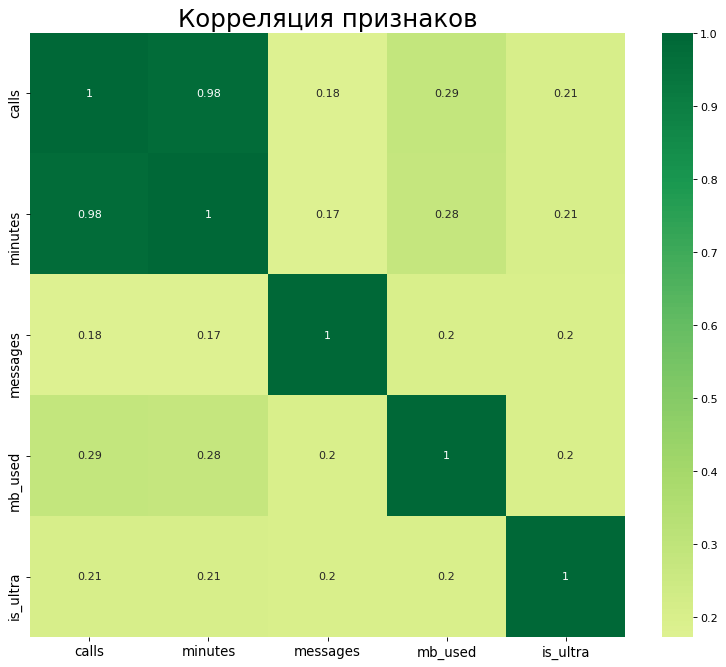

In [29]:
plt.figure(figsize=(12,10), dpi= 80)
sns.heatmap(data.corr(), xticklabels=data.corr().columns, 
            yticklabels=data.corr().columns, cmap='RdYlGn', center=0, annot=True)

plt.title('Корреляция признаков', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

<AxesSubplot:xlabel='calls', ylabel='minutes'>

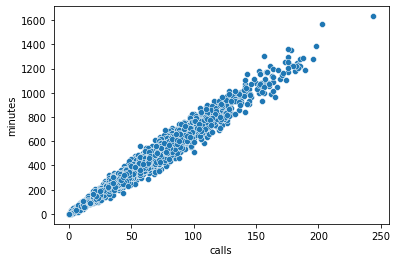

In [30]:
sns.scatterplot(data=data, x='calls', y='minutes')

1. Посмотрев таблицу еще раз я понял, что количесвто звонков и суммарная продолжительность имеют пряму связь между собой, т.к. сам факт числа звонков не так важен, как суммарная длительность этих звонков, то столбец 'calls' можно убрать

In [31]:
data = data.drop(['calls'], axis=1)

## Разбейте данные на выборки

In [32]:
features = data.drop(['is_ultra'], axis=1)
target = data['is_ultra']

In [33]:
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.2, 
                                                                              train_size=0.8, random_state=12345)

features_x, features_test, target_x, target_test = train_test_split(features, target, test_size=0.2, 
                                                                              train_size=0.75, random_state=12345)



In [34]:
features_train.shape, features_valid.shape, features_test.shape

((2571, 3), (643, 3), (643, 3))

## Исследуйте модели

In [51]:
def dtc_learn(features_train, target_train, features_valid,target_valid):
    best_model_DecisionTreeClassifier = None
    best_result_DecisionTreeClassifier = 0
    for depth in range(1, 20):
        for leaf_nodes in range(2,30):
            for sample_leaf in range (1, 30):
                model = DecisionTreeClassifier(random_state=12345,
                                               max_depth=depth, max_leaf_nodes=leaf_nodes, min_samples_leaf=sample_leaf) 
                # обучите модель с заданной глубиной дерева
                model.fit(features_train, target_train) # обучите модель
                predictions = model.predict(features_valid) # получите предсказания модели
                result = accuracy_score(predictions, target_valid) # посчитайте качество модели
                if result > best_result_DecisionTreeClassifier:
                    best_model_DecisionTreeClassifier = model
                    best_result_DecisionTreeClassifier = result
                    
    return best_model_DecisionTreeClassifier, best_result_DecisionTreeClassifier

In [52]:
%%time
best_model_result_DTC = dtc_learn(features_train, target_train, features_valid,target_valid)
print("Accuracy")     
print("Accuracy лучшей модели:", best_model_result_DTC[1])
print("Лучшая модель",best_model_result_DTC[0] )

Accuracy
Accuracy лучшей модели: 0.7962674961119751
Лучшая модель DecisionTreeClassifier(max_depth=6, max_leaf_nodes=17, min_samples_leaf=18,
                       random_state=12345)
Wall time: 1min 36s


In [53]:
def rfc_learn(features_train, target_train, features_valid,target_valid):
    best_model_RandomForest = None
    best_result_RandomForest = 0
    for depth in range(1,20):
        for est in range(1, 16):
            for leaf_node in range(2, 40):
                model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth, max_leaf_nodes=leaf_node) 
                # обучите модель с заданным количеством деревьев
                model.fit(features_train, target_train) 
                # обучите модель на тренировочной выборке
                result = model.score(features_valid, target_valid) 
                # посчитайте качество модели на валидационной выборке
                if result > best_result_RandomForest:
                    best_model_RandomForest =  model
                    # сохраните наилучшую модель
                    best_result_RandomForest = result
                    #  сохраните наилучшее значение метрики accuracy на валидационных данных
    return best_model_RandomForest, best_result_RandomForest 

In [54]:
%%time
best_model_result_RFC = rfc_learn(features_train, target_train, features_valid,target_valid)
print("Accuracy")     
print("Accuracy лучшей модели:", best_model_result_RFC[1])
print("Лучшая модель",best_model_result_RFC[0] )

Accuracy
Accuracy лучшей модели: 0.8118195956454122
Лучшая модель RandomForestClassifier(max_depth=11, max_leaf_nodes=37, n_estimators=10,
                       random_state=12345)
Wall time: 3min 26s


In [47]:

def MPLC_learn(features_train, target_train, features_valid,target_valid):
    best_model_MLPClassifier= None
    best_result_MLPClassifier = 0
    for iteration in range(200, 500):
        clf = MLPClassifier(solver = 'adam', random_state=12345, learning_rate='adaptive', 
                            max_iter=iteration).fit(features_train, target_train)
        clf_predict = clf.predict_proba(features_valid)
        clf_score_valid = clf.score(features_valid, target_valid)
        if clf_score_valid > best_result_MLPClassifier:
            best_model_MLPClassifier = clf
            best_result_MLPClassifier = clf_score_valid
            
    return best_model_MLPClassifier, best_result_MLPClassifier 

In [48]:
%%time
best_model_result_MPLC = MPLC_learn(features_train, target_train, features_valid,target_valid)
print("Accuracy")     
print("Accuracy лучшей модели:", best_model_result_MPLC[1])
print("Лучшая модель",best_model_result_MPLC[0] )

Accuracy
Accuracy лучшей модели: 0.6827371695178849
Лучшая модель MLPClassifier(learning_rate='adaptive', random_state=12345)
Wall time: 57.1 s


In [43]:

def sgd_learn(features_train, target_train, features_valid,target_valid):
    best_model_SGDClassifier = None
    best_result_SGDClassifier = 0
    for iteration in range(1000, 5000):
        SGD_model = make_pipeline(StandardScaler(),
                        SGDClassifier(max_iter=iteration, tol=1e-3, n_jobs=-1))
        SGD_model.fit(features_train, target_train)
        SGD_predict = SGD_model.predict(features_valid)
        SGD_score_valid = SGD_model.score(features_valid, target_valid)
        if SGD_score_valid > best_result_SGDClassifier:
            best_model_SGDClassifier = SGD_model
            best_result_SGDClassifier = SGD_score_valid

    return best_model_SGDClassifier, best_result_SGDClassifier

In [44]:
%%time
best_model_result_SGD = sgd_learn(features_train, target_train, features_valid,target_valid)
print("Accuracy")     
print("Accuracy лучшей модели:", best_model_result_SGD[1])
print("Лучшая модель",best_model_result_SGD[0] )

Accuracy
Accuracy лучшей модели: 0.7729393468118196
Лучшая модель Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdclassifier', SGDClassifier(max_iter=1237, n_jobs=-1))])
Wall time: 45.2 s


In [45]:

def gpc_learn(features_train, target_train, features_valid,target_valid):
    best_model_GaussianProcessClassifier = None
    best_result_GaussianProcessClassifier = 0
    kernel = 1.0 * RBF(1.0)
    for iteration in range(100, 200, 300):
        gpc_model = GaussianProcessClassifier(kernel=kernel,
            random_state=12345, max_iter_predict=iteration, multi_class='one_vs_one', n_jobs=-1).fit(features_train, target_train)
        gpc_predict = gpc_model.predict(features_valid)
        gpc_score_valid = gpc_model.score(features_valid, target_valid)
        if gpc_score_valid > best_result_GaussianProcessClassifier:
            best_model_GaussianProcessClassifier = gpc_model
            best_result_GaussianProcessClassifier = gpc_score_valid
            
    return best_model_GaussianProcessClassifier, best_result_GaussianProcessClassifier

In [46]:
%%time
best_model_result_GPC = gpc_learn(features_train, target_train, features_valid,target_valid)
print("Accuracy")     
print("Accuracy лучшей модели:", best_model_result_GPC[1])
print("Лучшая модель",best_model_result_GPC[0] )

C:\Users\Mikhail\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy
Accuracy лучшей модели: 0.6734059097978227
Лучшая модель GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1),
                          multi_class='one_vs_one', n_jobs=-1,
                          random_state=12345)
Wall time: 5.39 s


## Проверьте модель на тестовой выборке

In [63]:
model_DTC = best_model_result_DTC[0]
model_RFC = best_model_result_RFC[0]
model_MPLC = best_model_result_MPLC[0]
model_SGD = best_model_result_SGD[0]
model_GPC = best_model_result_GPC[0]

In [81]:
listed_models = [model_DTC, model_RFC, model_MPLC, model_SGD, model_GPC]

In [82]:
result = []
for model in listed_models:
    model.fit(features_train, target_train)
    result.append(model.score(features_test, target_test))
result

C:\Users\Mikhail\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


[0.7962674961119751,
 0.8118195956454122,
 0.6827371695178849,
 0.7060653188180405,
 0.6734059097978227]

## Проверьте модели на адекватность

In [87]:
%%time

from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(features_train, target_train)

dummy_clf_predict = dummy_clf.predict(features_valid)

dummy_clf_score = dummy_clf.score(features_test, target_test)

print("Accuracy")     
print("Accuracy лучшей модели:", dummy_clf_score)

Accuracy
Accuracy лучшей модели: 0.6951788491446346
Wall time: 1.97 ms


In [88]:
d = {'Models': ['DTC', 'RFC', 'MPLC', 'SGD', 'GPC', 'Dummy'], 'Result': [0.796,
 0.812,
 0.683,
 0.706,
 0.673,
0.695]}
df = pd.DataFrame(data=d)
df

,Models,Result
0,DTC,0.796
1,RFC,0.812
2,MPLC,0.683
3,SGD,0.706
4,GPC,0.673
5,Dummy,0.695


In [89]:
(0.812/0.695-1)*100

16.834532374100732

1. Моедли MLPClassifier и GaussianProcessClassifier уступает "Глупой модели" в показателях и можно говорить.
2. Без построения модели, мы потеряем ~11,7% точности, если будем просто использовать наиболее часто втречаемое значение, а точность лучшей модели превосходит DummyClassifier на 16,8%, при учете того, что у бизнеса может быть сотни тысяч или более клиентов, недополученая прибыль может многократно первосходить затраты на введение рекомендательной системы.

In [91]:
from sklearn.metrics import classification_report
y_true = target_test
y_pred = model_RFC.predict(features_test)

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.93      0.87       447
           1       0.78      0.54      0.63       196

    accuracy                           0.81       643
   macro avg       0.80      0.73      0.75       643
weighted avg       0.81      0.81      0.80       643



1. Наилучшие показатель точности показала модель RandomForestClassifier, скорость так же высока
2. Модель DecisionTreeClassifier показала чуть меньшую точность, а разница в скорости не так критична по сравнению с RandomForestClassifier
3. Моедли MLPClassifier и GaussianProcessClassifier можно считать худшими в данном случае.
6. Наибольшее влияние на точность оказывала:
        6.1. В случаях использования деревьев - их глубина
        6.2. В итерационных моделях, число итераций, но сверх высокие показатели числа итераций не делают модель более точной, а время затрачиваемое на обработку неоправданно велико

- [x] Выполнено задание 1: данные загружены и изучены
- [x] Выполнено задание 2: данные разбиты на три выборки
- [x] Выполнено задание 3: проведено исследование моделей
    - [x] Рассмотрено больше одной модели
    - [x] Рассмотрено хотя бы 3 значения гипепараметров для какой-нибудь модели
    - [x] Написаны выводы по результатам исследования
- [x] Выполнено задание 3: Проведено тестирование
- [x] Удалось достичь accuracy не меньше 0.75
